# CS410 Project

# Text Classification Competition: Twitter Sarcasm Detection 
----
Dataset format:

Each line contains a JSON object with the following fields : 
- ***response*** :  the Tweet to be classified
- ***context*** : the conversation context of the ***response***
	- Note, the context is an ordered list of dialogue, i.e., if the context contains three elements, `c1`, `c2`, `c3`, in that order, then `c2` is a reply to `c1` and `c3` is a reply to `c2`. Further, the Tweet to be classified is a reply to `c3`.
- ***label*** : `SARCASM` or `NOT_SARCASM` 

- ***id***:  String identifier for sample. This id will be required when making submissions. (ONLY in test data)

For instance, for the following training example : 

`"label": "SARCASM", "response": "@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..", "context": ["A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .", "@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯"]`

The response tweet, "@USER @USER @USER I don't get this..." is a reply to its immediate context "@USER If your child isn't..." which is a reply to "A minor child deserves privacy...". Your goal is to predict the label of the "response" while optionally using the context (i.e, the immediate or the full context).

***Dataset size statistics*** :

| Train | Test |
|-------|------|
| 5000  | 1800 |

For Test, we've provided you the ***response*** and the ***context***. We also provide the ***id*** (i.e., identifier) to report the results.

***Submission Instructions*** : Follow the same instructions as for the MPs -- create a private copy of this repo and add a webhook to connect to LiveDataLab.Please add a comma separated file named `answer.txt` containing the predictions on the test dataset. The file should have no headers and have exactly 1800 rows. Each row must have the sample id and the predicted label. For example:

twitter_1,SARCASM  
twitter_2,NOT_SARCASM  
...


# **1. Setup**

## 1.1 Open this file in google colab

If this file is not shown on the google colab environment, please right-click the button below(Open in Colab) and **open in new window or new tab**.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RyoTakaki/CourseProject/blob/main/SarcasmClassification.ipynb)

## 1.2 Change the google colab settings

We can use a GPU on the google colab by setting below.  
**Edit -> Notebook setting -> Hardware accelerator -> GPU**

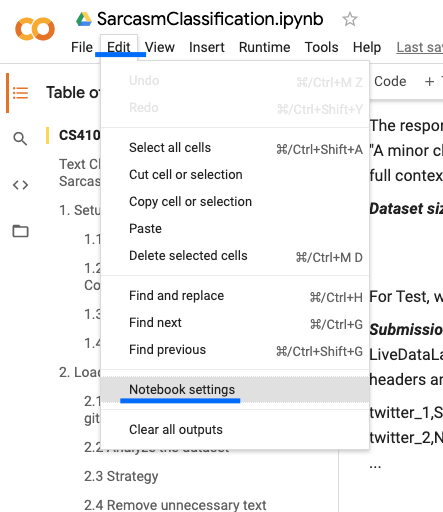

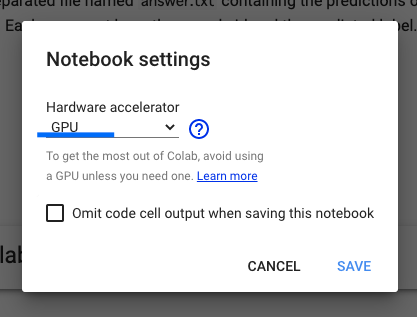

## 1.3 Check if the GPU is available in the Colab environment

In [1]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print('Device name: {}'.format(device_name))

Device name: /device:GPU:0


## 1.4 GPU setting for PyTourch

In [2]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import torch

# Tell PyTorch to use the GPU
device = torch.device("cuda")
print('GPU:', torch.cuda.get_device_name(0))

GPU: Tesla T4


## 1.5 Install the Hugging Face Library

In [3]:
# In order to use a BERT framework, install the Hugging Face library
!pip install transformers

     |████████████████████████████████| 1.4MB 19.9MB/s 
     |████████████████████████████████| 2.9MB 56.0MB/s 
     |████████████████████████████████| 890kB 60.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=30faccff078d2908abab74fb4ac5b687545df524f8b79ec31f312417652ba253
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# **2. Loading Dataset**

## 2.1 Download the twitter dataset from github repo

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=981a3167b00ac79cf0b826e326dd1224bcc684af3eddaf6c3e7903fdbf3017e1
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import wget
import os

# Download the training file from the project github repo
if not os.path.exists('./train.jsonl'):
    wget.download('https://github.com/CS410Fall2020/ClassificationCompetition/raw/main/data/train.jsonl')
    print('Downloading train.jsonl')
else:
    print('train.jsonl is already exist')

## 2.2 Analyze the dataset

To check if the training data is same as what we expect, display the total number of data and its contents.

In [6]:
import pandas as pd
# Load the train data as pandas dataframe
df = pd.read_json('./train.jsonl', orient='records', lines=True)

print('Number of training data: {:,}\n'.format(df.shape[0]))

# check the train data
df.sample(n=5, random_state=0)

Number of training data: 5,000



,label,response,context
398,SARCASM,Countered with #climatechange activists stuck ...,[One good #climatechange meme deserves a story...
3833,NOT_SARCASM,"@USER @USER @USER When we share love , we get ...","["" Heaven on Earth is a choice you must make ,..."
4836,NOT_SARCASM,@USER @USER @USER Give me nothing . Just sayin...,[@USER @USER @USER A question noone is asking ...
4572,NOT_SARCASM,🍗 Sinning happens nearly everywhere . As a res...,[🍗 The Spiritual explanation for cancer appear...
636,SARCASM,@USER I was going for the . PV method gives MM...,"[In PEI Electoral Reform Plebiscite , FPTP get..."


We can see that the data size is 5000 and the data has label, response and context information as expected.
Next, let's check the balance of a label distribution(how many data is SARCASM and NOT_SARCASM)

In [7]:
# Check the label distribution
print(df['label'].value_counts())

SARCASM        2500
NOT_SARCASM    2500
Name: label, dtype: int64



The train data is equally balanced in terms of the label. So, we can use these data as the training data set.

## 2.3 Make an initial strategy

Intuitively, we should use context information to judge if the response tweet is sarcasm or not. However, how many context tweets should we use? Before deciding the initial strategy, let's check how many tweets are stored as the context information.

As the all context information is stored in the "context" column regardless of the number of the context tweets, let's devide the context column's information into several tweets, count the number of divided context tweets as "comment_num", and save them as a nuw column(in this case, I only save the latest tweet as "pre_comment").

Text(0, 0.5, 'The number of data')

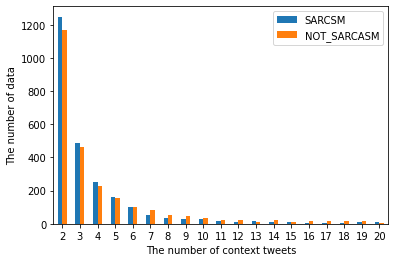

In [8]:
# Check a number of comments for each tweets
import re

# This function it to devide the several context tweets by using specific patterns
def split_context(a_string):
    stripped_string = str(a_string).strip('[]').strip('\'\"')
    pattern = '\", \"|\', \'|\', \"|\", \''
    splitted_string = re.split(pattern, stripped_string)
    splitted_string = [x for x in splitted_string if x is not None]
    return pd.Series([splitted_string[0], len(splitted_string)])

# Create "comment_num" column from context information
df[['pre_comment', 'comment_num']] = df['context'].apply(split_context)
#df.sample(n=5, random_state=0)

# Number of training data(SARCASM) corresponding to the number of comments
num_sarcasm_data_by_comments = df[df['label']=='SARCASM']['comment_num'].value_counts().sort_index()

# Number of training data(NON_SARCASM) corresponding to the number of comments
num_non_sarcasm_data_by_comments = df[df['label']=='NOT_SARCASM']['comment_num'].value_counts().sort_index()

# Graph
val1 = num_non_sarcasm_data_by_comments
val2 = num_sarcasm_data_by_comments
index = num_non_sarcasm_data_by_comments.index
df_plot = pd.DataFrame({'SARCSM': val1, 'NOT_SARCASM': val2}, index=index)
ax = df_plot.plot.bar(rot=0)
ax.set_xlabel('The number of context tweets')
ax.set_ylabel("The number of data")

We can see that at least two context tweets are included in each data. Based on this graph, I decided to use either 1 or 2 context tweets for input data. First, I will try to use only one context information as an initial strategy, but if it does not work well, I will try to use 2 context tweets for the input data.

## 2.4 Remove unnecessary text

As the contest has unnecessary text like "@USER", let's remove the unnecessary text.

In [9]:
# Remove unnecessary string(@USER)
def remove_strings(a_string):
    stripped_string = str(a_string).lstrip('(@USER )')
    return stripped_string

df['response'] = df['response'].apply(remove_strings)
df['pre_comment'] = df['pre_comment'].apply(remove_strings)
df.loc[:,['response', 'pre_comment']].sample(n=5, random_state=0)

,response,pre_comment
398,Countered with #climatechange activists stuck ...,One good #climatechange meme deserves a story ...
3833,"When we share love , we get love too . Our vib...","Heaven on Earth is a choice you must make , no..."
4836,Give me nothing . Just saying no one really kn...,A question noone is asking is ' Parnas the ins...
4572,🍗 Sinning happens nearly everywhere . As a res...,🍗 The Spiritual explanation for cancer appeari...
636,I was going for the . PV method gives MMP the ...,"In PEI Electoral Reform Plebiscite , FPTP gets..."


Now we can see that there is no "@USER" in the column "response" and "pre_comment".

## 2.5 Create numerical labels

To make the training easy, lets convert the current string lable to a numerical label(NOT_SARCASM -> 0, SARCASM -> 1)

In [10]:
# Convert the label into number
df['label_num'] = df['label'].apply(lambda x: 1 if x == 'SARCASM' else 0)
df.sample(n=5, random_state=0)
df.loc[:,['label', 'label_num']].sample(n=5, random_state=0)

,label,label_num
398,SARCASM,1
3833,NOT_SARCASM,0
4836,NOT_SARCASM,0
4572,NOT_SARCASM,0
636,SARCASM,1


Now we can see the numerical labels(label_num: 0/1) were generated from the labels(SARCASM or NOT_SARCASM).

# 3. Tokenization and Input formatting

## 3.1 BERT Tokenizer

In order to input the tweets to the BERT, the tweets need to be tokenized. The library can handle this BERT tokenizer as following.

In [11]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/

from transformers import  BertTokenizer
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Let's check how the tweets are converted to the BERT token.

In [12]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/

print(' Original: ', df['response'][1])
print('Tokenized: ', tokenizer.tokenize(df['response'][1]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['response'][1])))

 Original:  trying to protest about . Talking about him and his labels and they label themselves WTF does that make em ?
Tokenized:  ['trying', 'to', 'protest', 'about', '.', 'talking', 'about', 'him', 'and', 'his', 'labels', 'and', 'they', 'label', 'themselves', 'w', '##tf', 'does', 'that', 'make', 'em', '?']
Token IDs:  [2667, 2000, 6186, 2055, 1012, 3331, 2055, 2032, 1998, 2010, 10873, 1998, 2027, 3830, 3209, 1059, 24475, 2515, 2008, 2191, 7861, 1029]


As we can see, the original tweet was converted to the tokenized words and its token ID.

## 3.2 Formatting for BERT

### 3.2.1 Check maximum tweet length

In order to use the libraty we need to define the maximum input length. As we decided to use the response and only the latest context tweet, let's concatenate those sentences and save then as a new column of the pandas dataframe.

In [13]:

def make_input_pair(df):
    return [df['response'], df['pre_comment']]

df['input_pair'] = df.apply(make_input_pair, axis=1)

print('[response]: {}' .format(df['response'][0]))
print('[pre_comment]: {}' .format(df['pre_comment'][0]))
print('')
print('----------------')
print('These two sentences above are concanated')
print('[input_pair]: {}' .format(df['input_pair'][0]))

[response]: I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..
[pre_comment]: A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .

----------------
These two sentences above are concanated
[input_pair]: ["I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..", 'A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .']


We were able to concatenate two two sentences, let's check the maximum tweet length of the concatenated sentences.

In [14]:
# The code in this cell is inspired by https://huggingface.co/transformers/v2.4.0/glossary.html
# encoded_sequence = tokenizer.encode(sequence_a, sequence_b)

def get_input_len(df):    
    return len(tokenizer.encode(df['input_pair'][0], df['input_pair'][1]))
df['len_input_pair'] = df.apply(get_input_len, axis=1)
print('The maximum length of the input is {}' .format(df['len_input_pair'].max()))

The maximum length of the input is 180


-> We will use "185" as the maximum length (actual max length(180) + margin(5))

### 3.2.2 Data encoding

In [15]:
# The code in this cell is inspired by the tech report made by my UIUC's class mate(zen030).
# https://github.com/zen030/tech_review/blob/master/techreview.pdf


# Encoding
encoded_data = tokenizer.batch_encode_plus(
                    df['input_pair'],
                    add_special_tokens=True,
                    return_attention_mask=True,
                    max_length=185,
                    padding='max_length',
                    return_tensors='pt'                    
                )

# Convert the lists into tensors
input_ids_all = encoded_data['input_ids']
attention_masks_all = encoded_data['attention_mask']
labels_all = torch.tensor(df['label_num'].values)
token_type_ids_all = encoded_data['token_type_ids']

In [16]:
print(encoded_data['input_ids'][0])

tensor([  101,  1045,  2123,  1005,  1056,  2131,  2023,  1012,  1012,  5525,
         2017,  2079,  2729,  2030,  2017,  2052,  1005,  2310,  2333,  2157,
         2247,  1012,  1012,  2612,  2017,  2787,  2000,  2729,  1998, 18792,
         2014,  1012,  1012,   102,  1037,  3576,  2775, 17210,  9394,  1998,
         2323,  2022,  2921,  2041,  1997,  4331,  1012, 17217,  6382,  2319,
         1010,  2017,  2323,  2022, 14984,  1997,  2115,  2200,  4854,  1998,
         5525, 25352,  2270,  6090,  4063,  2075,  1010,  1998,  2478,  1037,
         2775,  2000,  2079,  2009,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

We can see that input ids were padding with zero until the maxmum length(185)

In [17]:
print(encoded_data['attention_mask'][0])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


We can see that the attention mask shows that input ids generated from the actual tweets correspond to 1. (0 if for padding)

In [18]:
print(encoded_data['token_type_ids'][0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Also, we can see that the response and the context ids correspond to 0 and 1 respectively in the token_type_ids.

# 4. Training and Valication Split

## 4.1 Devide the data set into the trining data set and the validation data set

In [19]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
from torch.utils.data import TensorDataset, random_split

# For reproducing the same result
seed_val = 34 
torch.manual_seed(seed_val)

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids_all, attention_masks_all, labels_all, token_type_ids_all)

# Training: 90%, Validation: 10%
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Select the data randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Chcek the number of data just in case
print('Training data: {}'.format(train_size))
print('Validation data: {}'.format(val_size))

Training data: 4500
Validation data: 500


Data set were divided into the training data and validation data as expcted ratio.

## 4.2 Creaiting the Data Loaders

In [20]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 16 or 32 are recommended by the BERT author
batch_size = 32 

# DataLoaders for the training data set
train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=batch_size
        )

# DataLoaders for the validation data set
validation_dataloader = DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=batch_size
        )

# 5. Train the model

## 5.1 Model definition

In [21]:
# The code in this cell is inspired by https://huggingface.co/transformers/model_doc/bert.html
# and https://mccormickml.com/2019/07/22/BERT-fine-tuning/


from transformers import BertForSequenceClassification, AdamW, BertConfig
# "BertForSequenceClassification" consitsts of the pre-trained BERT model
# and single linear classification layer.

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # SARCASM or NOT_SARCASM
    output_attentions = False,
    output_hidden_states = False,
)

# The model will be on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 5.2 Change trainable parameters

Finally, I decided not to change the trainable parameters of the BERT model.However, those parameters can be changed by eanbling the cell below if needed for your project.
In this tutorial, I will skip explaining the detail of this cell.

In [22]:
# Change trainable parameters
# https://github.com/huggingface/transformers/issues/400

# When I fixed the BERT pretrained paramters for the model training, final performance for our project was not better than that of the unfixed version.
# So, the code below are now commented out.
'''
for name, param in model.named_parameters():
    if 'classifier' not in name: # classifier layer
        #print(param.requires_grad)
        param.requires_grad = False

for name, param in model.named_parameters():
    print(param.requires_grad)
'''

"\nfor name, param in model.named_parameters():\n    if 'classifier' not in name: # classifier layer\n        #print(param.requires_grad)\n        param.requires_grad = False\n\nfor name, param in model.named_parameters():\n    print(param.requires_grad)\n"

## 5.3 Optimizer and Learning Rate Scheduler

In [23]:
# The code in this cell is inspired by the tech report made by my UIUC's class mate(zen030).
# https://github.com/zen030/tech_review/blob/master/techreview.pdf

# The learning rate and epsiron values are included in the values recommended by the BERT author.

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
# From 2 to 4 is recommended by the BERT author.
epochs = 2

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## 5.4 Training loop

As we should reuse existing codes as much as possible (with proper citation), I decided to borrow the code from the below tutorial for the model training
https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [25]:
import numpy as np

# This function is to calcurate the accuracy of the model predicetion vs groundtruth(labels)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
import time
import datetime

# This function is for formatting the time to display understandably
def format_time(elapsed):    
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [27]:
import random
import numpy as np

# For reproducing the same result
# seed_val = 34 # Already defined
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Save the start time
total_t0 = time.time()

# Epoch loop
print(' ========================================================= ')
print(' === The model training will take about 5 minutes. Just a moment please. ===')
print(' ========================================================= ')
for epoch_i in range(0, epochs):
    

    # ----------------------------------------- #
    # (1) Training phase
    # ----------------------------------------- #
    # Perform one full pass over the training set.    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print(' ----------------------------------------- ')
    print(' (1) Training phase ')
    print(' ----------------------------------------- ')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # Batch loop
    for step, batch in enumerate(train_dataloader):

        # Display the elapsed time
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Copy the batch data to the GPU        
        b_input_ids = batch[0].to(device) # batch[0]: input ids 
        b_input_mask = batch[1].to(device) # batch[1]: attention masks
        b_labels = batch[2].to(device) # batch[2]: labels 
        b_token_type_ids = batch[3].to(device) # batch[3]: token_type_ids 

        # Clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass
        outputs = model(b_input_ids, 
                             # token_type_ids=None, 
                             token_type_ids=b_token_type_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        # print(outputs)
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ----------------------------------------- #
    # (2) Validation phase
    # ----------------------------------------- #
    print("")
    print(' ----------------------------------------- ')
    print(' (2) Validation phase ')
    print(' ----------------------------------------- ')

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Batch loop
    for batch in validation_dataloader:
        
        # Copy the batch data to the GPU
        b_input_ids = batch[0].to(device)  # batch[0]: input ids 
        b_input_mask = batch[1].to(device) # batch[1]: attention masks
        b_labels = batch[2].to(device) # batch[2]: labels 
        b_token_type_ids = batch[3].to(device) # batch[3]: token_type_ids 
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   # token_type_ids=None,
                                   token_type_ids=b_token_type_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
              
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Copy the logits and the labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

print('')
print(' --------------- Finish --------------- ')
print("Total training time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

 === The model training will take about 5 minutes. Just a moment please. ===

======== Epoch 1 / 2 ========
 ----------------------------------------- 
 (1) Training phase 
 ----------------------------------------- 
  Batch    10  of    141.    Elapsed: 0:00:11.
  Batch    20  of    141.    Elapsed: 0:00:22.
  Batch    30  of    141.    Elapsed: 0:00:34.
  Batch    40  of    141.    Elapsed: 0:00:45.
  Batch    50  of    141.    Elapsed: 0:00:56.
  Batch    60  of    141.    Elapsed: 0:01:07.
  Batch    70  of    141.    Elapsed: 0:01:18.
  Batch    80  of    141.    Elapsed: 0:01:29.
  Batch    90  of    141.    Elapsed: 0:01:40.
  Batch   100  of    141.    Elapsed: 0:01:51.
  Batch   110  of    141.    Elapsed: 0:02:02.
  Batch   120  of    141.    Elapsed: 0:02:13.
  Batch   130  of    141.    Elapsed: 0:02:24.
  Batch   140  of    141.    Elapsed: 0:02:35.

  Average training loss: 0.55
  Training epcoh took: 0:02:36

 ----------------------------------------- 
 (2) Validation ph

In order to check if the model training is good enough(not underfit and not overfit), we should check the accuracy and the losses by changing the number or epocs etc. However, in my case, the F1 score for the test data set using this model beat the baseline performance even though it was a first trial. As our goal is to beat the baseline performance (not to beat the all competitors), I decided to finish the model training with these parameters. 

# 6. Evaluate on Test set

## 6.1 Test data download

In [28]:
# Download the test file from project github repo
if not os.path.exists('./test.jsonl'):
    wget.download('https://github.com/CS410Fall2020/ClassificationCompetition/raw/main/data/test.jsonl')
    print('Downloading test.jsonl')
else:
    print('test.jsonl is already exist')

In [29]:
import pandas as pd
# Load the train data as pandas dataframwe
df = pd.read_json('./test.jsonl', orient='records', lines=True)

print('Number of training data: {:,}\n'.format(df.shape[0]))

# check the train data
df.sample(n=5, random_state=0)

Number of training data: 1,800



,id,response,context
597,twitter_598,@USER @USER @USER I see what you did there ! N...,[Pelosi and her corrupt-hate filled Democrats ...
831,twitter_832,"@USER Also , thanks for your kind words .",[After such a shitty day / week / month / LIFE...
1174,twitter_1175,@USER @USER Why should so-called ‘ universal l...,"[Gotta say , ' Horrible Histories ' - which is..."
467,twitter_468,@USER @USER Pierre Delecto always knows how to...,[Well well well . Maybe this backlash against ...
1722,twitter_1723,@USER @USER @USER they were murdered in a plac...,"[Two years ago today , a gunman entered Marjor..."


As we can see, the correct labels are not included as it is test data, but the other data is same as training data set.

## 6.2 Create the "pre_comment" column by dividing the context infomation

In [30]:
import re

def split_context(a_string):
    stripped_string = str(a_string).strip('[]').strip('\'\"')
    pattern = '\", \"|\', \'|\', \"|\", \''
    splitted_string = re.split(pattern, stripped_string)
    splitted_string = [x for x in splitted_string if x is not None]
    return pd.Series([splitted_string[0], len(splitted_string)])

# Create "comment_num" column from context information
df[['pre_comment', 'comment_num']] = df['context'].apply(split_context)
# df.sample(n=5, random_state=0)

## 6.3 Remove the unnecessary string(@USER)

In [31]:
def remove_strings(a_string):
    stripped_string = str(a_string).lstrip('(@USER )')
    return stripped_string

df['response'] = df['response'].apply(remove_strings)
df['pre_comment'] = df['pre_comment'].apply(remove_strings)
# df.sample(n=5, random_state=0)

## 6.4 Concatenate the response and the pre comment

In [32]:
def make_input_pair(df):
    return [df['response'], df['pre_comment']]

df['input_pair'] = df.apply(make_input_pair, axis=1)
# df.sample(n=5, random_state=0)

## 6.5 Check the maxmum input length

In [33]:
def test_func(df):    
    return len(tokenizer.encode(df['input_pair'][0], df['input_pair'][1]))

df['len_input_pair'] = df.apply(test_func, axis=1)
print(df['len_input_pair'].max())
print(' Confirmed that the maximum length(185) is good enough for the test set as well')

157
 Confirmed that the maximum length(185) is good enough for the test set as well


## 6.6 Data Encoding and Data loader creating

In [34]:
encoded_data = tokenizer.batch_encode_plus(
                    df['input_pair'],
                    add_special_tokens=True,
                    return_attention_mask=True,
                    max_length=185,
                    padding='max_length',
                    return_tensors='pt'                    
                )

In [35]:
# Convert the lists into tensors
input_ids_test = encoded_data['input_ids']
attention_masks_test = encoded_data['attention_mask']
token_type_ids_test = encoded_data['token_type_ids']
# labels_test = torch.tensor(df['label_num'].values)

In [36]:
batch_size = 32

# Combine the training inputs into a TensorDataset.0
#dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataset = TensorDataset(input_ids_test, attention_masks_test, token_type_ids_test)

prediction_dataloader = DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

## 6.7 Prediction on test data

Prediction on the test data is done by using the same procedure as the validation data set

In [37]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Predictions
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_token_type_ids = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      # token_type_ids=None, 
                      token_type_ids=b_token_type_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('')
print(' --------------- Finish --------------- ')

Predicting labels for 1,800 test sentences...

 --------------- Finish --------------- 


## 6.8 Softmax and convert the numerical label(0/1) to the string label(SARCASN/NOT_SARCASM)

In [38]:
df['predicted_value'] = [item for l in predictions for item in l]
df['pred_flat'] = [np.argmax(item) for l in predictions for item in l]
df['pred_flat_label'] = df['pred_flat'].apply(lambda x: 'SARCASM' if x==1 else 'NOT_SARCASM')
df.loc[:,['id', 'response', 'pre_comment', 'pred_flat_label']]

,id,response,pre_comment,pred_flat_label
0,twitter_1,"My 3 year old , that just finished reading Nie...",Well now that ’ s problematic AF <URL>,NOT_SARCASM
1,twitter_2,"How many verifiable lies has he told now ? 15,...",Last week the Fake News said that a section of...,SARCASM
2,twitter_3,Maybe Docs just a scrub of a coach ... I mean ...,Let ’ s Aplaud Brett When he deserves it he co...,SARCASM
3,twitter_4,is just a cover up for the real hate inside @U...,Women generally hate this president . What's u...,SARCASM
4,twitter_5,The irony being that he even has to ask why .,"Dear media Remoaners , you excitedly sharing c...",SARCASM
...,...,...,...,...
1795,twitter_1796,is definitely the best out there . No question...,I have been a business customer of MWeb @USER ...,NOT_SARCASM
1796,twitter_1797,Ye let her out run wild and infect 10000 more ...,A woman refuses to have her temperature taken ...,SARCASM
1797,twitter_1798,"Thanks for that , I would have never known .",The reason big government wants @USER out is b...,SARCASM
1798,twitter_1799,Yes also #found this on #new with loads of <UR...,Happy #musicmonday and #thanks for #all your 😎...,NOT_SARCASM


We can see that the label(NOT_SARCASM or SARCASM) was pridicted based on the response and the latest context information.

## 6.9 Save the predicted results to csv

In [39]:
# Save the pridicted string label as text file without index and header
df.loc[:, ['id', 'pred_flat_label']].to_csv('reproduced_answer.txt', sep=',', index=False, header=False)

You can see the reproduced_answer.txt is generated in the folder below.
If you cannot see the file, please reload the page by clicking the folder icon.

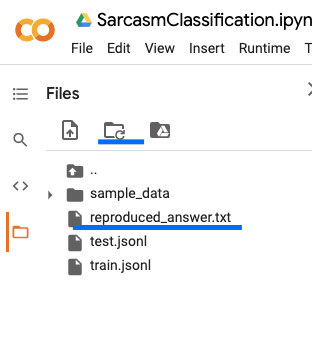

# 7. Comapre to the submitted prediction result

## 7.1 Download the submitted prediction file

In [40]:
import wget
import os

# Download the submitted prediction file from my project github repo
if not os.path.exists('./answer.txt'):
    wget.download('https://raw.githubusercontent.com/RyoTakaki/CourseProject/main/answer.txt')
    print('Downloading the answer.txt')
else:
    print('answer.txt is already exist')

## 7.2 Compare the answer.txt and the reproduced_answer.txt

In [41]:
import pandas as pd
# Load the answer.txt and the reproduced_answer.txt as pandas dataframe
df = pd.read_csv('./answer.txt', header=None, names=["id","Pred_original"])
df_tmp = pd.read_csv('./reproduced_answer.txt', header=None, names=["id","Pred_reproduce"])
df = df.merge(df_tmp)
df['Same'] = (df['Pred_original'] == df['Pred_reproduce'])
df

,id,Pred_original,Pred_reproduce,Same
0,twitter_1,NOT_SARCASM,NOT_SARCASM,True
1,twitter_2,SARCASM,SARCASM,True
2,twitter_3,SARCASM,SARCASM,True
3,twitter_4,SARCASM,SARCASM,True
4,twitter_5,SARCASM,SARCASM,True
...,...,...,...,...
1795,twitter_1796,NOT_SARCASM,NOT_SARCASM,True
1796,twitter_1797,SARCASM,SARCASM,True
1797,twitter_1798,SARCASM,SARCASM,True
1798,twitter_1799,NOT_SARCASM,NOT_SARCASM,True


In [42]:
same_data = (df['Same'] == True)
print('{} / {} data is same'.format(same_data.sum(), len(same_data)))

1800 / 1800 data is same


We can see that all the predition results are same as the submitted predictions.